https://www.tensorflow.org/tutorials/generative/dcgan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
import wandb

import common

2023-02-14 16:27:21.942390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Only use 1 GPU
devices = tf.config.list_physical_devices()[:2]
tf.config.set_visible_devices(devices)

2023-02-14 16:27:23.260179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:27:23.260421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:27:23.266278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:27:23.266495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:27:23.266668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
# Enable dynamic memory allocation on GPU for better usage monitoring
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
config = dict(
    noise_dim = 100,
    epochs = 20,
    batch_size = 32,

    g_optimizer = "adam",
    g_learning_rate = 1e-4,

    d_optimizer = "adam",
    d_learning_rate = 1e-4
)

In [5]:
run = wandb.init(project="mnist_dcgan", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dwl2x. Use `wandb login --relogin` to force relogin


In [8]:
# def load_dataset(run):
#     # Load the dataset
#     (x_train, _), _ = tf.keras.datasets.mnist.load_data()

#     # Normalize between 0.0 and 1.0
#     x_train = x_train / 255.0

#     return x_train

def load_dataset_from_artifact(run):
    path = run.use_artifact("dwl2x/mnist_dataset/mnist:v1").download()
    x_train = np.load(os.path.join(path, "mnist.npz"))["images"]
    return x_train

In [9]:
x_train = load_dataset_from_artifact(run)
x_train.shape

wandb:   1 of 1 files downloaded.  


(60000, 28, 28, 1)

In [10]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

In [11]:
def create_generator(config):
    y = x = tf.keras.layers.Input((config["noise_dim"],))

    # Project and normalize the batch
    y = tf.keras.layers.Dense(7*7*256, use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)

    # Reshape to be processed by a Conv2DTranspose
    y = tf.keras.layers.Reshape((7, 7, 256))(y)

    # Conv2DTranspose Block
    y = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)

    # Conv2DTranspose Block
    y = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)

    y = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")(y)

    # Create the model
    generator = tf.keras.models.Model(x, y)
    generator.compile(
        optimizer=common.select_optimizer(config["g_optimizer"])(config["g_learning_rate"])
    )
    return generator


def create_discriminator(config):
    # Accept any image as input
    y = x = tf.keras.layers.Input((28, 28, 1))

    # Conv2D Block
    y = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = tf.keras.layers.Dropout(0.3)(y)

    # Conv2D Block
    y = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = tf.keras.layers.Dropout(0.3)(y)

    # Project to a single output unit
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(1)(y)

    # Create the model
    discriminator = tf.keras.models.Model(x, y)
    discriminator.compile(
        optimizer=common.select_optimizer(config["d_optimizer"])(config["d_learning_rate"])
    )
    return discriminator

In [12]:
def generator_loss(fake_output):
    # We want to fool the discriminator, so the target is 1
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True)

def discriminator_loss(real_output, fake_output):
    # target vs. prediction
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True) # should predict ones
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output, from_logits=True) # should predict zeros
    return real_loss + fake_loss

@tf.function
def train_step(config, images, generator, discriminator):
    # Generate some noise to use for each batch
    noise = tf.random.normal([images.shape[0], config["noise_dim"]])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate some random images from the generator
        gen_images = generator(noise, training=True)

        # Evaluate a batch of real and fake images against the discriminator
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_images, training=True)

        # Compute the loss for both models
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients for both models
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients
    generator.optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_output, fake_output

In [13]:
def gen_images(generator, test_input):
    predictions = generator(test_input)
    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap="gray")
        plt.axis("off")
    return fig

def train(run, config, dataset, generator, discriminator):

    # Generate some random noise to display the progress
    test_input = tf.random.normal([16, config["noise_dim"]])

    num_batches = int(np.ceil(x_train.shape[0] / config["batch_size"]))

    for epoch in range(config["epochs"]):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        gen_accuracy = 0
        disc_accuracy = 0
        for batch_index in range(num_batches):
            print(f"\rBatch: {batch_index+1}/{num_batches}", end="")
            batch = dataset[batch_index*config["batch_size"]:(batch_index+1)*config["batch_size"]]

            gen_loss, disc_loss, real_pred, fake_pred = train_step(config, batch, generator, discriminator)
            total_gen_loss += np.mean(gen_loss)
            total_disc_loss += np.mean(disc_loss)
            gen_accuracy += tf.where(fake_pred >= 0.5).shape[0] / config["batch_size"]
            disc_accuracy += (tf.where(real_pred >= 0.5).shape[0] + tf.where(fake_pred < 0.5).shape[0]) / (2*config["batch_size"])

        total_gen_loss /= num_batches
        total_disc_loss /= num_batches
        gen_accuracy /= num_batches
        disc_accuracy /= num_batches

        fig = gen_images(generator, test_input)
        tf.print(f"\rEpoch {epoch} completed. Total epoch time: {time.time() - start:0.2} seconds.")

        run.log({
            "epoch": epoch + 1,
            "generator_accuracy": gen_accuracy,
            "discriminator_accuracy": disc_accuracy,
            "generator_loss": float(total_gen_loss),
            "discriminator_loss": float(total_disc_loss),
            "evaluation": fig
        })

In [14]:
generator = create_generator(config)
discriminator = create_discriminator(config)

2023-02-14 16:29:03.974675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 16:29:03.976671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:29:03.976909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 16:29:03.977078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Batch:  0

2023-02-14 16:29:05.615176: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-14 16:29:05.712162: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


Epoch 0 completed. Total epoch time: 9.7 seconds.
Epoch 1 completed. Total epoch time: 7.5 seconds.
Epoch 2 completed. Total epoch time: 7.4 seconds.
Epoch 3 completed. Total epoch time: 7.5 seconds.
Epoch 4 completed. Total epoch time: 7.7 seconds.
Epoch 5 completed. Total epoch time: 7.4 seconds.
Epoch 6 completed. Total epoch time: 7.5 seconds.
Epoch 7 completed. Total epoch time: 7.5 seconds.
Epoch 8 completed. Total epoch time: 7.5 seconds.
Epoch 9 completed. Total epoch time: 7.7 seconds.
Epoch 10 completed. Total epoch time: 7.5 seconds.
Epoch 11 completed. Total epoch time: 7.4 seconds.
Epoch 12 completed. Total epoch time: 7.4 seconds.
Epoch 13 completed. Total epoch time: 7.5 seconds.
Epoch 14 completed. Total epoch time: 7.4 seconds.
Epoch 15 completed. Total epoch time: 7.6 seconds.
Epoch 16 completed. Total epoch time: 7.5 seconds.
Epoch 17 completed. Total epoch time: 7.3 seconds.
Epoch 18 completed. Total epoch time: 7.5 seconds.
Epoch 19 completed. Total epoch time: 7.5

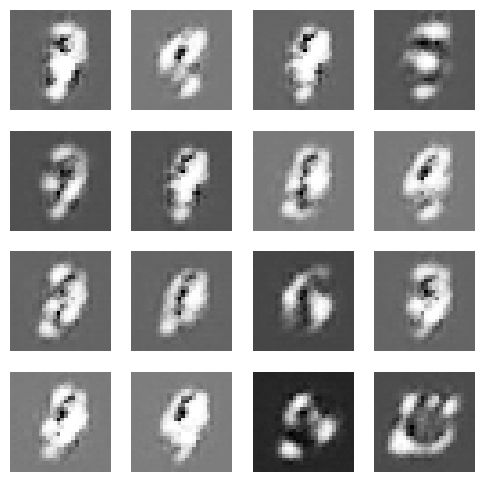

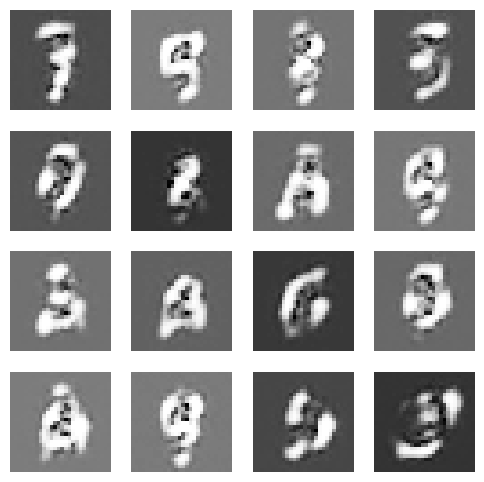

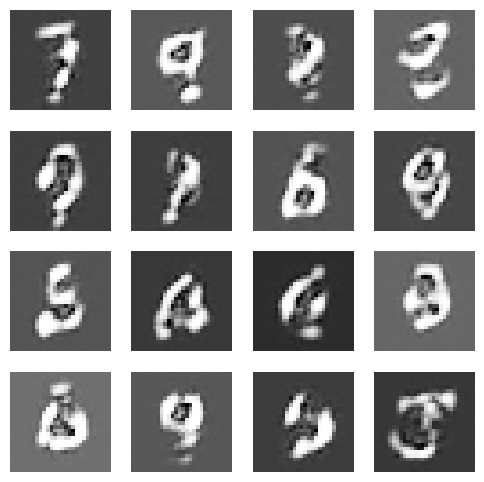

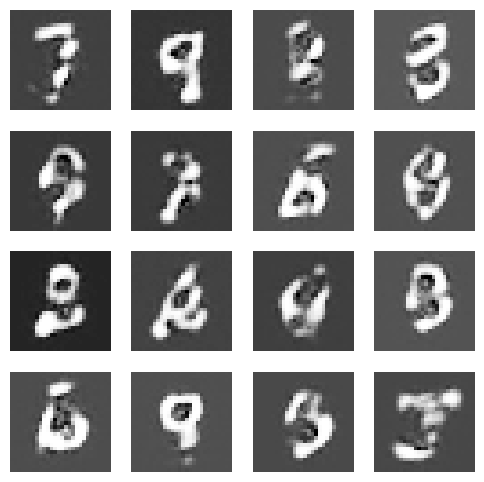

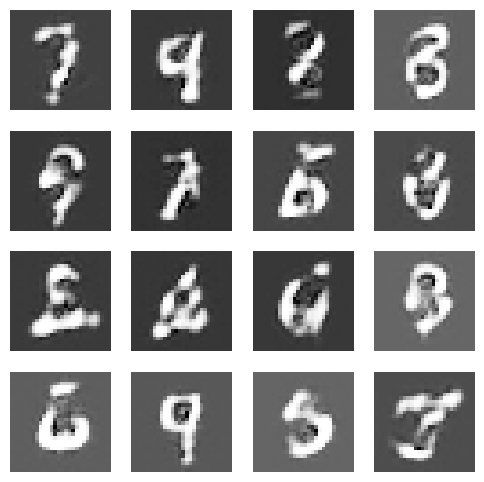

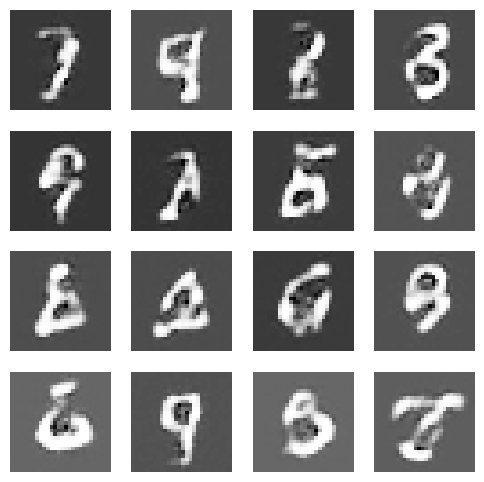

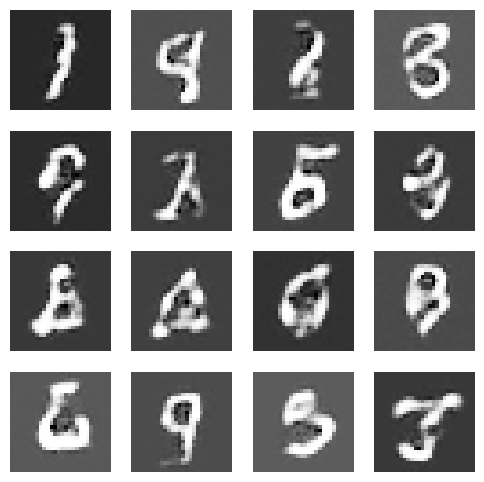

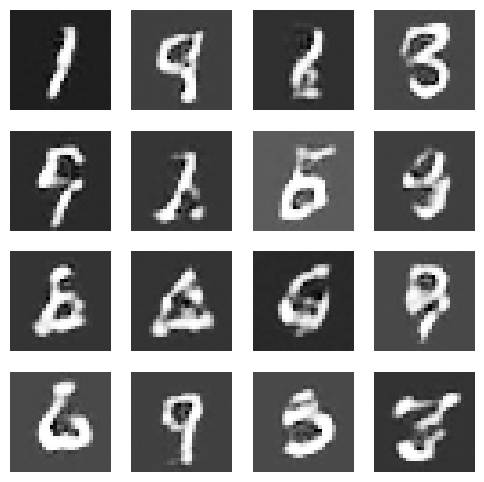

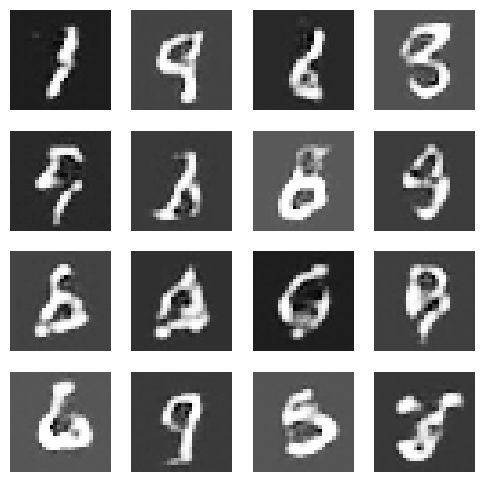

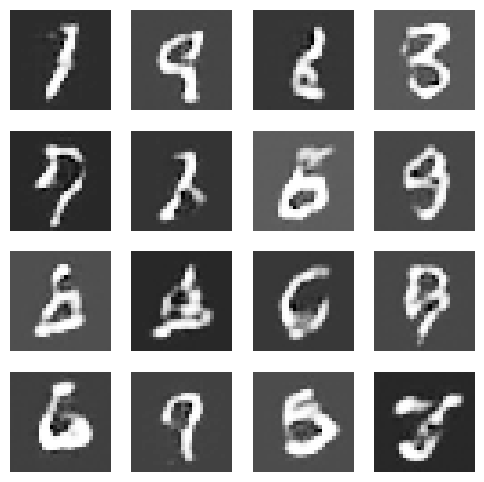

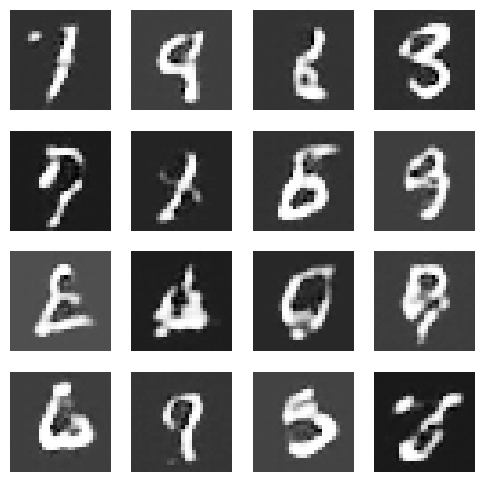

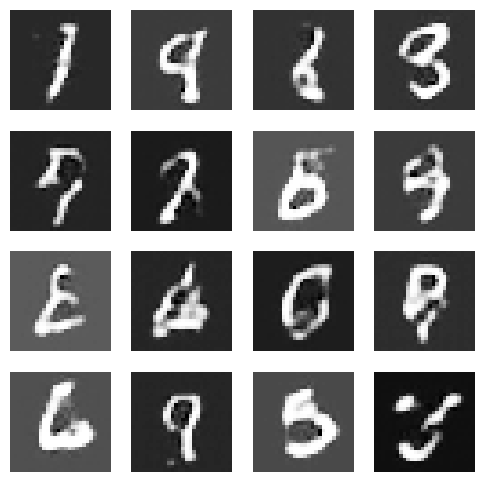

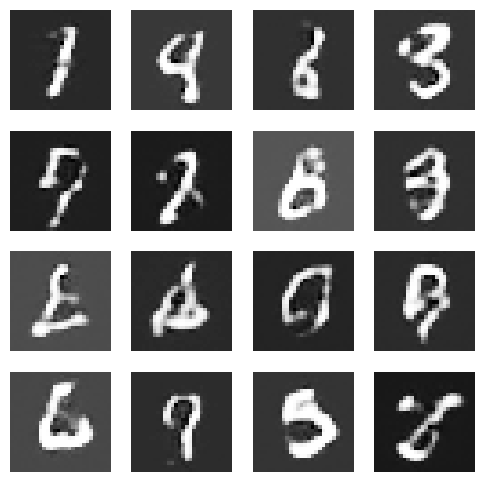

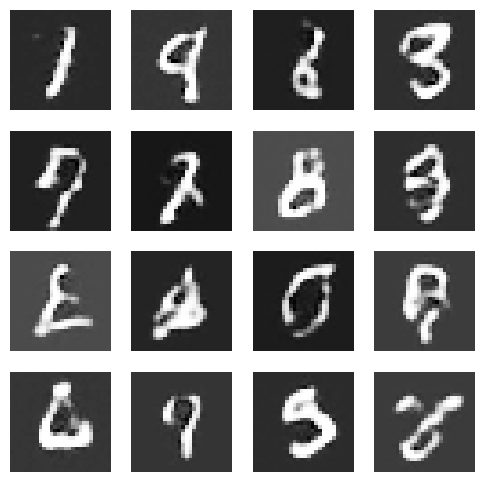

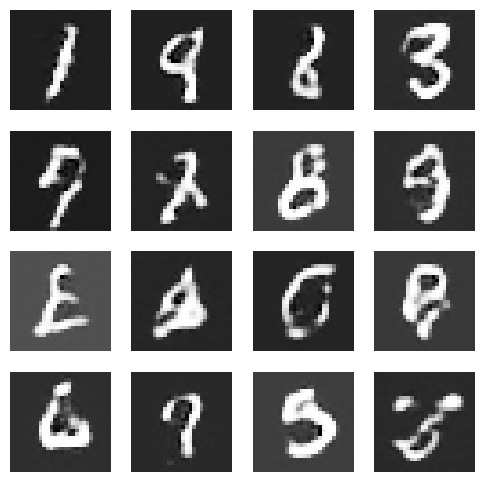

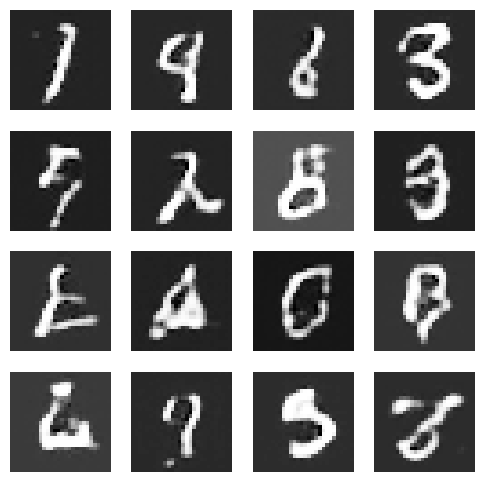

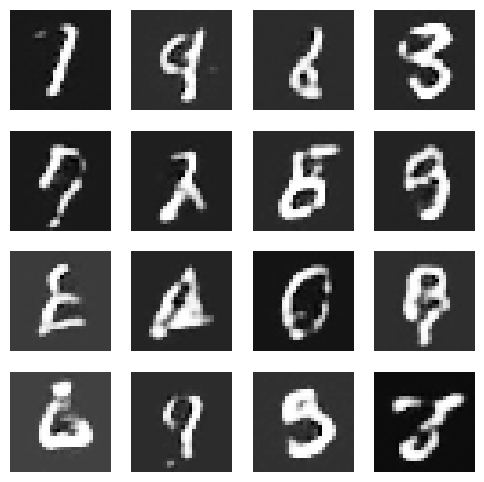

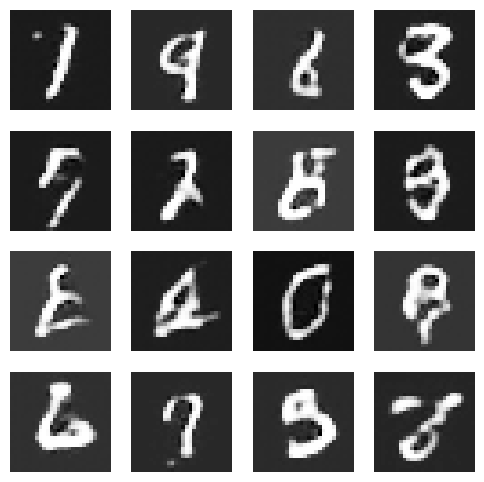

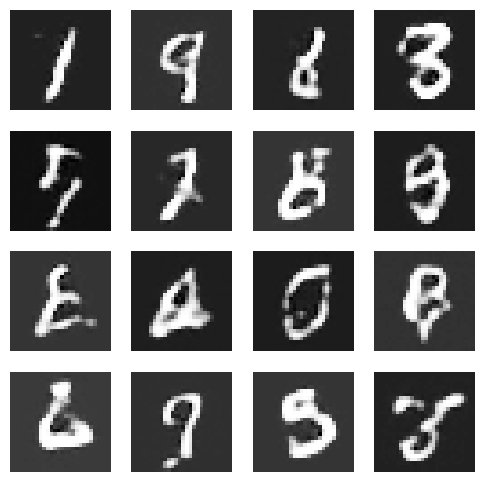

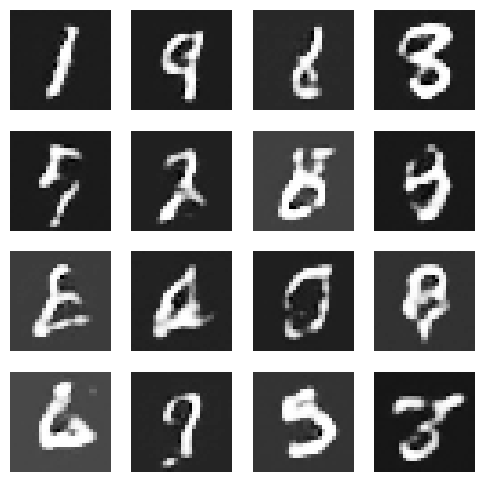

In [15]:
train(run, config, x_train, generator, discriminator)

In [18]:
save_path = os.path.join(run.dir, "generator")
save_path

'/home/dwl2x/Research/Seminar/wandb/run-20230214_162724-xl33vnn7/files/generator'

In [19]:
generator.save(save_path)

INFO:tensorflow:Assets written to: /home/dwl2x/Research/Seminar/wandb/run-20230214_162724-xl33vnn7/files/generator/assets


INFO:tensorflow:Assets written to: /home/dwl2x/Research/Seminar/wandb/run-20230214_162724-xl33vnn7/files/generator/assets


In [20]:
artifact = wandb.Artifact("mnist-generator", type="model")
artifact.add_dir(save_path)
run.log_artifact(artifact)

wandb: Adding directory to artifact (/home/dwl2x/Research/Seminar/wandb/run-20230214_162724-xl33vnn7/files/generator)... Done. 0.1s


In [21]:
run.finish()

discriminator_accuracy,▁▇████▇▇▇▇▇▇▇▇▇▇▇▇██
discriminator_loss,█▃▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
generator_accuracy,▁▅▆▆▆▇▇▇███████▇▇▇▇▇
generator_loss,▁▄▆▇████▇▇▇▇▇▇▇▇▇███
discriminator_accuracy,0.87182
discriminator_loss,0.58943
epoch,20
generator_accuracy,0.05797
generator_loss,2.16734
